In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

perc_test = 0.2      # Percentage data in test
batch_size = 100     # Number of rows in a batch for neural network training

# load data and one hot encode some of the categorical features

df = pd.read_csv("PeerLoanKart_fraud.csv")

df.rename(columns={"Loan Repayment Status": "target"}, inplace=True)
df["target"] = (df["target"]!="Paid")*1
df = pd.concat((df, pd.get_dummies(df["purpose"], dtype="int")), axis=1)

# Select input variables and target variable

features = ['credit_card',
            'debt_consolidation',
            'educational',
            'home_improvement',
            'major_purchase',
            'small_business',
            'log.annual.inc',
            'fico',
            'delinq.2yrs',
            'pub.rec',
#            'credit.policy',
            'int.rate',
            'installment',
            'days.with.cr.line',
            'inq.last.6mths',
            'dti',
            'revol.util',
            'revol.bal',
          ]

target = ['target',
         ]

X = df[features]
y = df[target]

# Normalize all features that have large deviations

#numerical_features = ['fico',
#                      'log.annual.inc',
#                      'installment',
#                      'days.with.cr.line',
#                      'dti',
#                      'revol.util',
#                      'revol.bal',
#                      'inq.last.6mths',
#                     ]

numerical_features = features

def normalize(X):
    X.loc[:, numerical_features] = (X[numerical_features] - X[numerical_features].mean())/X[numerical_features].std()
    return X

X = normalize(X)

#purposes = ['all_other', 'credit_card', 'debt_consolidation', 'educational', 'home_improvement', 'major_purchase', 'small_business']

#for i, purpose in enumerate(purposes):
#    Xnorm = normalize(X[X[purpose]==1])
#    if i==0:
#        Xcat = Xnorm
#    else:
#        Xcat = pd.concat((Xcat, Xnorm), axis=0)
#X = Xcat

# Split data into train/test datasets and create data loader for PyTorch

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=perc_test, random_state=123, shuffle=True)

Xt_train = torch.tensor(X_train.values).float()
yt_train = torch.tensor(y_train.values).float()
Xt_test = torch.tensor(X_test.values).float()
yt_test = torch.tensor(y_test.values).float()

train_dataset = TensorDataset(Xt_train, yt_train)
train_loader = DataLoader(train_dataset, batch_size = batch_size)

In [2]:
y.value_counts()

target
0         8045
1         1533
Name: count, dtype: int64

In [3]:
# Load all libraries for models

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import torch
from torch import nn
from torch.nn import functional as F
from skorch import NeuralNetClassifier, NeuralNet
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import joblib

In [5]:
# Performance Metrics Functions

def lift_plot(y, pred, Nq, title="Lift Plot"):
    X = pd.DataFrame({"target": y["target"], "score": pd.qcut(pred[:,1], Nq).map(lambda x: x.left, na_action=None)})
    Xg = X[["score", "target"]].value_counts().unstack(-1)
    Xg["lift"] = Xg[1]/(Xg[0] + Xg[1])
    Xg["lift"].plot(kind="bar")
    plt.xlabel("score quantile bins")
    plt.ylabel("Percentage Positives")
    plt.title(title)
    plt.plot()

{'C': 0.1}


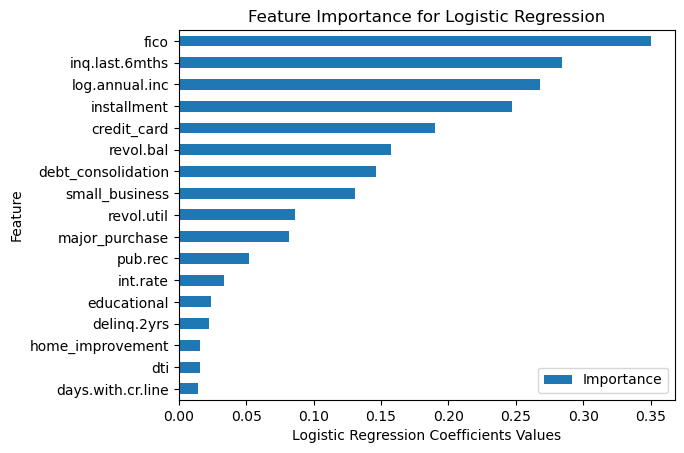

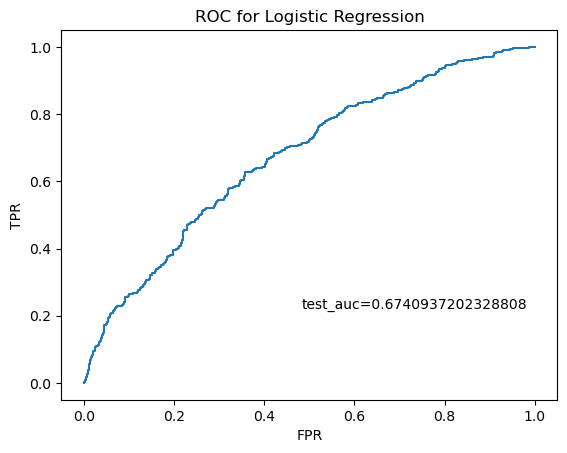

['logistic_regression_credit.joblib']

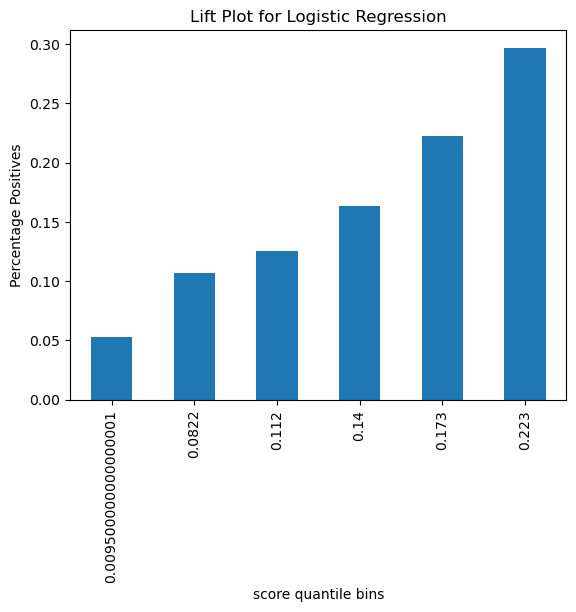

In [9]:
# Classifier used
clf = LogisticRegression(random_state=123)

# Parameters for grid search cross validation. Here just search L2 regularization coefficient
param_grid = {'C': [0.05, 0.1, 0.2]}

# Run cross validation, optimizing on AUC
gs = GridSearchCV(clf, param_grid = param_grid, cv=3, n_jobs=4, scoring='roc_auc')
gs.fit(X_train, y_train["target"])

# Get best classifier and get score on test input data
clf_best = gs.best_estimator_
pred = clf_best.predict_proba(X_test)

# Return best parameters from grid search
print(gs.best_params_)

# Plot logistic regression slope coefficients. Because input is normalized the coefficients are proportional to the importance of the
# input variable
coefficients = clf_best.coef_[0]
feature_importance = pd.DataFrame({'Feature': X_test.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh')
plt.title("Feature Importance for Logistic Regression")
plt.xlabel("Logistic Regression Coefficients Values")
plt.show()

# Plot ROC curve and return area under the curve of the ROC
fpr, tpr, thresholds = roc_curve(y_test["target"], pred[:,1])
test_roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC for Logistic Regression")
plt.figtext(0.5,0.3, "test_auc=" + str(test_roc_auc))
plt.show()

# Plot Lift Plots
lift_plot(y_test, pred, 6, "Lift Plot for Logistic Regression")

# Save model as a joblib file
joblib.dump(clf_best, "logistic_regression_credit.joblib")

{'max_depth': 6, 'n_estimators': 200}


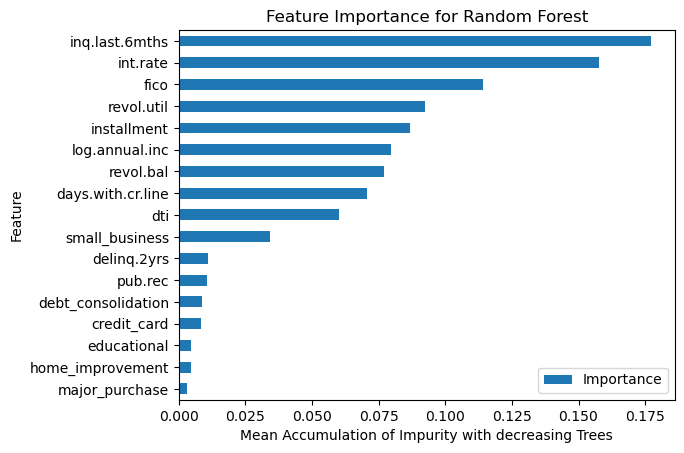

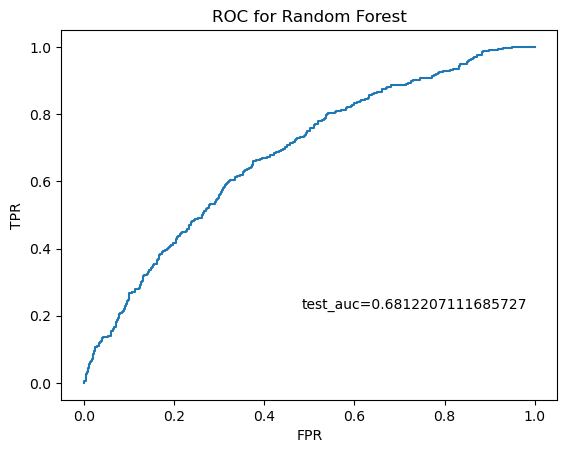

['random_forest_credit.joblib']

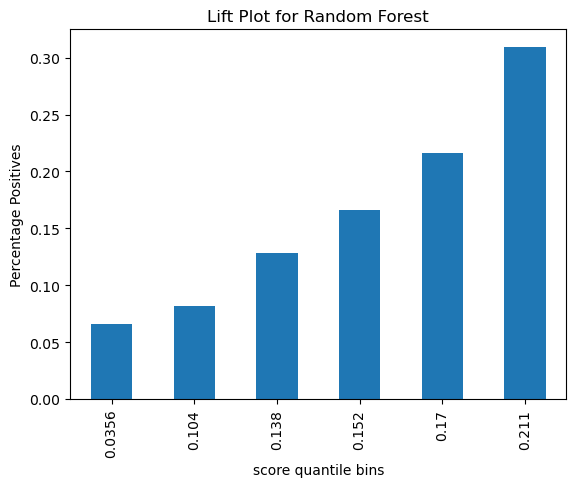

In [8]:
# Classifier used
clf = RandomForestClassifier(random_state=123)

# Parameters for grid search cross validation. Here search number of trees and max_depth (regularization)
param_grid = {'n_estimators':[50, 100, 150, 200],
              'max_depth':[4, 5, 6]}

# Run cross validation, optimizing on AUC
gs = GridSearchCV(clf, param_grid = param_grid, cv=3, n_jobs=4, scoring='roc_auc')
gs.fit(X_train, y_train["target"])

# Get best classifier and get score on test input data
clf_best = gs.best_estimator_
pred = clf_best.predict_proba(X_test)

# Return best parameters from grid search
print(gs.best_params_)

# For tree based models the feature importance is measured by the mean decrease in impurity i.e. the sum over the number of splits
# that include the feature proportionally to the number of samples it splits. 
coefficients = clf_best.feature_importances_
feature_importance = pd.DataFrame({'Feature': X_test.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh')
plt.title("Feature Importance for Random Forest")
plt.xlabel("Mean Accumulation of Impurity with decreasing Trees")
plt.show()

# Plot ROC curve and return area under the curve of the ROC
fpr, tpr, thresholds = roc_curve(y_test["target"], pred[:,1])
test_roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC for Random Forest")
plt.figtext(0.5,0.3, "test_auc=" + str(test_roc_auc))
plt.show()

# Plot Lift Plots
lift_plot(y_test, pred, 6, "Lift Plot for Random Forest")

# Save model as a joblib file
joblib.dump(clf_best, "random_forest_credit.joblib")

{'eta': 0.1, 'gamma': 0.1, 'max_depth': 3, 'n_estimators': 50, 'reg_alpha': 0.1, 'reg_lambda': 0.005}
num_trees 50


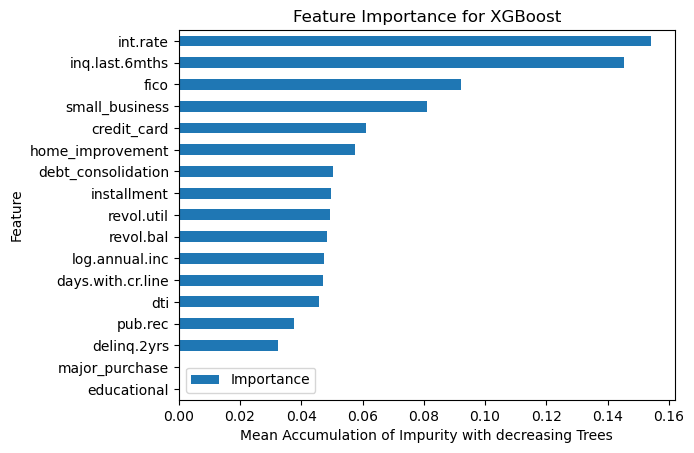

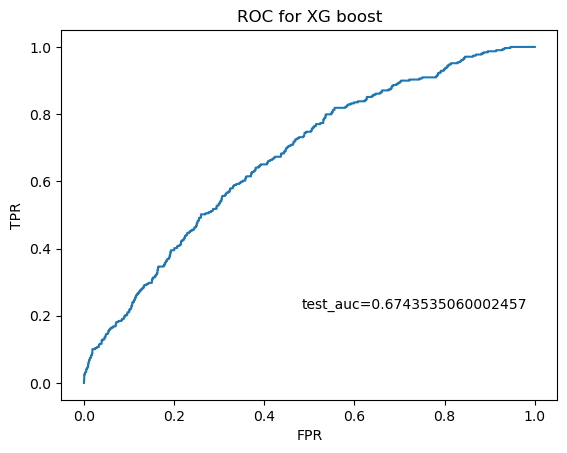

['xgboost_credit.joblib']

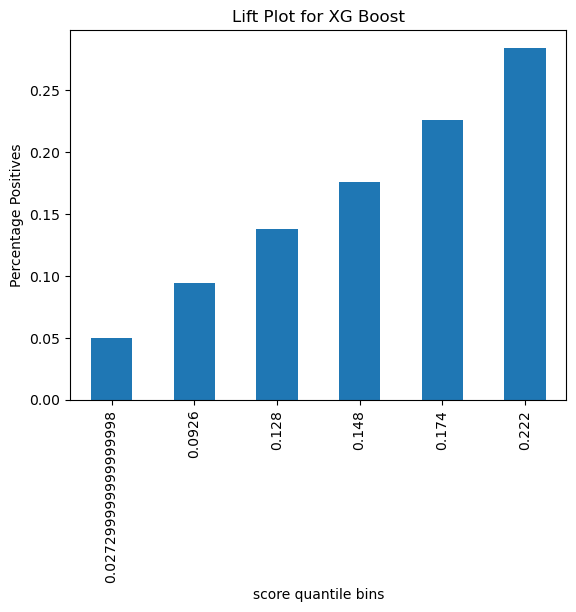

In [10]:
# Classifier used
clf = xgb.XGBClassifier(tree_method='auto', seed=123, early_stopping_rounds=20) #reg_lambda=0.01, reg_alpha=0.1, gamma=0.31

# Parameters for grid search cross validation. Here search number of boosting rounds, steps size, and regularization parameters
# min sample % for split, maximum tree depth, L1 and L2 regularization coefficients
param_grid = {'n_estimators': [50, 75, 100],
              'eta': [0.1, 0.2, 0.3, 0.4, 0.5],
              'gamma': [0.1, 0.2, 0.3],
              'max_depth': [3, 4, 5],
              'reg_lambda': [0.005, 0.01, 0.015],
              'reg_alpha': [0.05, 0.1, 0.15]}

# Run cross validation, optimizing on AUC
gs = GridSearchCV(clf, param_grid = param_grid, cv=3, n_jobs=4, scoring='roc_auc')
gs.fit(X_train, y_train["target"], eval_set=[(X_test, y_test["target"])], verbose=False)

# Get best classifier and get score on test input data
clf_best = gs.best_estimator_
pred = clf_best.predict_proba(X_test)

# Return best parameters from grid search
print(gs.best_params_)
print('num_trees', len(clf_best.get_booster().get_dump()))

# For tree based models the feature importance is measured by the mean decrease in impurity i.e. the sum over the number of splits
# that include the feature proportionally to the number of samples it splits. 
coefficients = clf_best.feature_importances_
feature_importance = pd.DataFrame({'Feature': X_test.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh')
plt.title("Feature Importance for XGBoost")
plt.xlabel("Mean Accumulation of Impurity with decreasing Trees")
plt.show()

# Plot ROC curve and return area under the curve of the ROC
fpr, tpr, thresholds = roc_curve(y_test["target"], pred[:,1])
test_roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC for XG boost")
plt.figtext(0.5,0.3, "test_auc=" + str(test_roc_auc))
plt.show()

# Plot Lift Plots
lift_plot(y_test, pred, 6, "Lift Plot for XG Boost")

# Save model as a joblib file
joblib.dump(clf_best, "xgboost_credit.joblib")

{'criterion__weight': tensor([1., 1.]), 'max_epochs': 30, 'module__act1': 'sigmoid', 'module__act2': 'sigmoid', 'module__dropout': 0.2, 'optimizer__lr': 0.01}


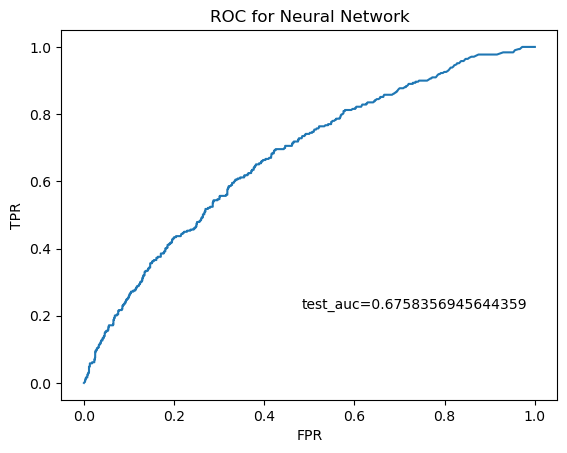

['nnet_credit.joblib']

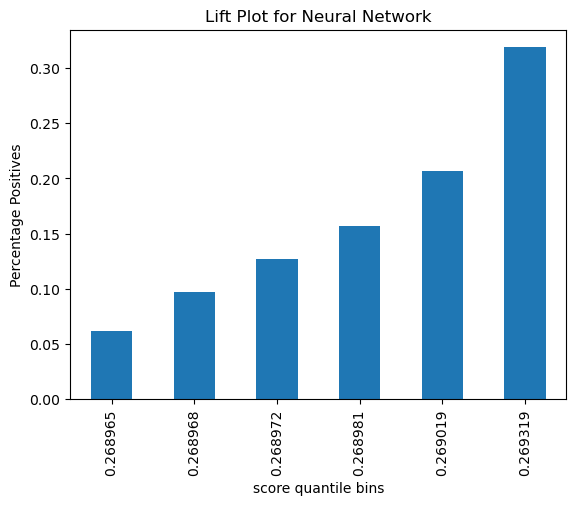

In [9]:
class TwoLayerNeuralNetwork(nn.Module):

    def __init__(self, n_input, n_hidden1, act1, n_hidden2, act2, n_output, dropout):
        super().__init__()
        self.hidden1 = nn.Linear(n_input, n_hidden1)
        self.dropout1 = nn.Dropout(dropout)
        self.n_hidden1 = n_hidden1
        self.act1 = act1
        self.hidden2 = nn.Linear(n_hidden1, n_hidden2)
        self.dropout2 = nn.Dropout(dropout)
        self.n_hidden2 = n_hidden2
        self.act2 = act2
        self.output = nn.Linear(n_hidden2, n_output)

    def forward(self, x_in):
        # First Hidden Layer
        if self.act1 == "relu":
            x_1 = F.relu(self.hidden1(x_in))
        if self.act1 == "sigmoid":
            x_1 = F.sigmoid(self.hidden1(x_in))
        x_1 = self.dropout1(x_1)
        # Second Hidden Layer
        if self.act2 == "relu":
            x_2 = F.relu(self.hidden2(x_1))
        if self.act2 == "sigmoid":
            x_2 = F.sigmoid(self.hidden2(x_1))
        # Allow for projection bypass layer if available
        if self.n_hidden1 == self.n_hidden2:
            x_2 = x_2 + x_1
        x_out = self.dropout2(x_2)
        # Softmax the output layer so sum of probabilities is equal to one
        x_out = F.softmax(self.output(x_out), dim=1)
        return x_out


clf = NeuralNetClassifier(
    module = TwoLayerNeuralNetwork,
    criterion = torch.nn.CrossEntropyLoss,
    optimizer = torch.optim.AdamW,
    verbose = False,
    max_epochs = 20,
    module__n_input = 17,
    module__n_hidden1 = 8,
    module__act1 = "relu",
    module__n_hidden2 = 17,
    module__act2 = "sigmoid",
    module__n_output = 2,
    module__dropout = 0.1,          # Percentage of Node dropout during training
    device = "cpu"
)

param_grid = {
    'max_epochs': [20, 30 ,40],
    'optimizer__lr': [0.005, 0.01, 0.02],
    'criterion__weight': [torch.tensor([2.0, 1.0]), torch.tensor([1.0, 1.0])],
    'module__act1': ['relu', 'sigmoid'],
    'module__act2': ['relu', 'sigmoid'],
    'module__dropout': [0.1, 0.2],
}

# Run cross validation, optimizing on AUC
gs = GridSearchCV(clf, param_grid = param_grid, cv=3, n_jobs=4, scoring='roc_auc')
gs.fit(Xt_train, yt_train.flatten().long())

# Get best classifier and get score on test input data
clf_best = gs.best_estimator_
pred = clf_best.predict_proba(Xt_test)

# Return best parameters from grid search
print(gs.best_params_)

# Plot ROC curve and return area under the curve of the ROC
fpr, tpr, thresholds = roc_curve(y_test["target"], pred[:,1])
test_roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC for Neural Network")
plt.figtext(0.5,0.3, "test_auc=" + str(test_roc_auc))
plt.show()

# Plot Lift Plots
lift_plot(y_test, pred, 6, "Lift Plot for Neural Network")

# Save model as a joblib file
joblib.dump(clf_best, "nnet_credit.joblib")

Text(0.5, 1.0, 'Neural Network Layer 1')

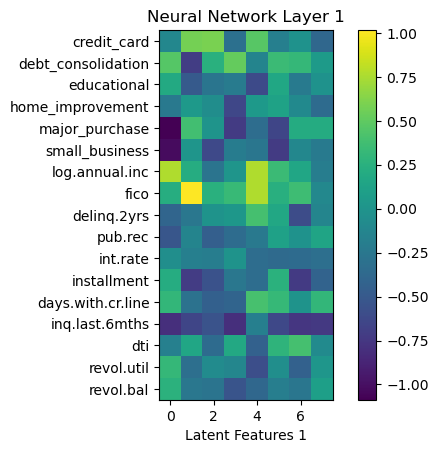

In [112]:
x = clf_best.module_.hidden1.state_dict()["weight"].detach().numpy().transpose()
plt.imshow(x)
plt.colorbar()
plt.yticks(range(len(features)), features)
plt.xlabel("Latent Features 1")
plt.title("Neural Network Layer 1")

Text(0.5, 1.0, 'Neural Network Layer 2')

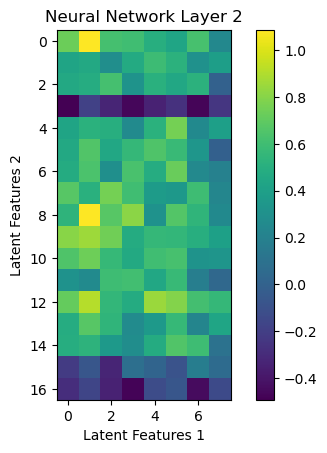

In [113]:
x = clf_best.module_.hidden2.state_dict()["weight"].detach().numpy()
plt.imshow(x)
plt.colorbar()
plt.xlabel("Latent Features 1")
plt.ylabel("Latent Features 2")
plt.title("Neural Network Layer 2")